# 🎼 Uncovering Hidden Patterns in Music: A Genre Clustering Approach Using Audio Features

## 📘 Quick Navigation

Use the links below to jump to major sections of this report:

- ### **1.** [Gather Data & Define the Problem](#1.4-Import,-load-and-basic-view-data)
- ### **2.** [Identify the Unsupervised Learning Problem](#2.-Identify-the-Unsupervised-Learning-Problem)
- ### **3.** [Exploratory Data Analysis (EDA)](#3:-Exploratory-Data-Analysis-(EDA))
  - [3.1 Data Quality & Preprocessing](#3.1-Data-Quality-&-Preprocessing)
  - [3.2 Feature Distributions & Relationships](#3.2-Feature-Distributions-&-Relationships)
  - [3.3 Dimensionality Reduction & Visualization](#3.3-Dimensionality-Reduction-&-Visualization)
- ### **4.** [Model Analysis & Comparison](#4-Model-Analysis-&-Comparison)
  - [4.1 K-Means Clustering](#4.1-k-Means-Clustering)
  - [4.2 Gaussian Mixture Models](#4.2-Gaussian-Mixture-Models)
  - [4.3 DBSCAN](#4.3-DBSCAN)
  - [4.4 Hierarchical & Spectral Clustering](#4.4-(Bonus)-Hierarchical-&-Spectral-Clustering)
  - [4.5 Cross‐Model Comparison](#4.5-Cross‐Model-Comparison)
- ### **5.** [Evaluation & Interpretation](#5-Evaluation-&-Interpretation)
- ### **6.** [Conclusion & Future Directions](#6-Conclusion-&-Future-Directions)
- ### **7.** [Reflection & Lessons Learned](#7-Reflection-&-Lessons-Learned)
- ### **8.** [References & Appendix](#8-References-&-Appendix)


---

## 1. Gather Data & Define the Problem

### 1.1 Data Source & Provenance

- **Dataset**: FMA-Small subset of the Free Music Archive (∼8,000 tracks, 30-second clips)
- **Download Source**: [FMA GitHub](https://github.com/mdeff/fma) / [FMA-Small Archive](http://os.unil.cloud.switch.ch/fma/fma_small.zip)
- **Download Date**: May-07-2025
- **License**: Creative Commons BY 4.0 (credit: Defferrard et al., 2017)

**Audio Features Used:**
- Precomputed: tempo, spectral centroid, zero crossing rate, MFCCs (20), chroma features, etc.
- Stored in: `features.csv`
- Metadata (e.g., top-level genre labels) stored in: `tracks.csv`

*Optional*: Audio files from `fma_small.zip` are available for augmentation but are not used in this analysis.

---
### 1.2 Problem Definition

The goal of this project is to **discover natural groupings of musical tracks** based purely on their **audio features**, using **unsupervised clustering**. Importantly, **genre labels are not used during training**, but are retained for **post-hoc evaluation** of the cluster structure.

- **Learning task**: Clustering (unsupervised)
- **Scope**:
  - Only audio feature data is used for training (no artist or metadata).
  - The analysis compares multiple clustering algorithms to determine which best captures meaningful musical groupings.
  - Evaluation includes both internal cluster metrics and external comparison to 8+ top-level genre labels.


### 1.3 Set up necessary libraies and tools for analysis

In [82]:
# Set up necessary libraies and tools for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from scipy.cluster.hierarchy import linkage, dendrogram

### 1.4 Import, load and basic view data

In [2]:
# Load feature and track metadata files
features_path = 'data/features.csv'
tracks_path = 'data/tracks.csv'

# Multi-indexed column loading
features = pd.read_csv(features_path, index_col=0, header=[0, 1, 2])
tracks = pd.read_csv(tracks_path, index_col=0, header=[0, 1])

print("Features shape:", features.shape)
print("Tracks shape:", tracks.shape)

Features shape: (106574, 518)
Tracks shape: (106574, 52)


In [3]:
# Get top-level genre labels (8 broad genres)
genre_labels = tracks[('track', 'genre_top')]

# Optional: Display counts per genre
print("Genre distribution (top-level):")
print(genre_labels.value_counts())

Genre distribution (top-level):
(track, genre_top)
Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: count, dtype: int64


*While the dataset includes 106,574 tracks in total, we restrict our analysis to the **8,000-track "fma_small" subset**, which aligns with the available audio and feature files.*

---

## 2. Identify the Unsupervised Learning Problem 

### 2.1 Task: Clustering (No Label Supervision)

This project frames the problem as a **clustering task**, where we aim to group musical tracks based solely on their extracted audio features. No genre labels are used during the learning process. Labels are only used later for **post-hoc evaluation**.

---

### 2.2 Feature Space

- The dataset contains **over 500 audio features** per track.
- These include **mean**, **variance**, and **standard deviation** statistics for features like MFCCs, chroma, spectral bandwidth, and zero-crossing rate.
- For model input, we will start with the **mean values only**, which gives us 74 features after selecting only the mean statistics.
- Dimensionality reduction via **Principal Component Analysis (PCA)** will be used to reduce redundancy and improve clustering stability.
- Optionally, nonlinear reduction techniques like **autoencoders** or **UMAP** may be considered for visualization.

---

### 2.3 Algorithms to Compare

We will evaluate and compare **at least two clustering algorithms**:

- **K-Means Clustering**: Creates hard partition clusters based on minimizing within-cluster variance.
- **Gaussian Mixture Models (GMM)**: Provides soft probabilistic assignments using multivariate normal distributions.

We also do optional models:
- **Spectral Clustering**: Uses eigenvectors of similarity graph for clustering.
- **DBSCAN**: Density-based clustering that can identify arbitrarily shaped clusters and outliers.

---

### 2.4 Hyperparameter Selection Plan

Each model has key hyperparameters that will be optimized using appropriate methods:

- **K-Means**:
  - Use **Elbow Method** to find optimal number of clusters `k`
  - Use **Silhouette Score** and **Davies–Bouldin Index** for quality assessment

- **GMM**:
  - Optimize number of components using **Bayesian Information Criterion (BIC)** and **Akaike Information Criterion (AIC)**
  - Evaluate results with **Silhouette Score** and cluster “softness”

- **DBSCAN** (if used):
  - Perform a **grid search** over `epsilon` and `min_samples`
  - Evaluate with **number of clusters**, **noise points**, and **Silhouette Score**


In [8]:
fma_small_dir = 'data/fma_small'

# Correctly walk through all subfolders and collect integer track IDs
fma_small_ids = []

for root, dirs, files in os.walk(fma_small_dir):
    for file in files:
        if file.endswith('.mp3'):
            # Convert zero-padded filename to integer track ID
            track_id = int(file.split('.')[0])
            fma_small_ids.append(track_id)

# Check sample
print("First 5 track IDs from fma_small:", fma_small_ids[:5])

# Ensure feature index is integer
X.index = X.index.astype(int)

# Filter feature matrix
X_small = X.loc[X.index.isin(fma_small_ids)]

print("Filtered feature matrix shape (fma_small only):", X_small.shape)

X_small.head()

First 5 track IDs from fma_small: [2, 5, 10, 140, 141]
Filtered feature matrix shape (fma_small only): (8000, 74)


feature  chroma_cens                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
2           0.474300  0.369816  0.236119  0.228068  0.222830  0.221415   
5           0.258420  0.303385  0.250737  0.218562  0.245743  0.236018   
10          0.229882  0.286978  0.240096  0.226792  0.192443  0.288410   
140         0.161163  0.272767  0.295905  0.255588  0.260886  0.252854   
141         0.150417  0.155785  0.217253  0.224969  0.273518  0.295436   

feature                                           ... spectral_contrast  \
number          07        08        09        10  ...                06   
track_id                                          ...                     
2         0.229238  0.248795  0.196245  0.175809  ...         17.616112   
5         0.275766  0.293982  0.346324  0.289821  ...         19.255819   
10        0.413348  0.349137  0.268424  0.243144  ...         18.967014   
140       0.193282  0.191970  0.291551  0.319938  ...         19.176929   
141       0.259958  0.181313  0.177233  0.296048  ...         23.950989   

feature             spectral_rolloff   tonnetz                                \
number           07               01        01        02        03        04   
track_id                                                                       
2         38.268646      3267.804688 -0.002570  0.019296  0.010510  0.073464   
5         36.413609      2773.931885 -0.007501 -0.018525 -0.030318  0.024743   
10        34.886196      2603.491943 -0.021650 -0.018369 -0.003282 -0.074165   
140       36.932270      2583.014160  0.005231 -0.007988 -0.101991  0.003448   
141       29.015615      1905.394531  0.010864  0.009294 -0.053343 -0.075120   

feature                            zcr  
number          05        06        01  
track_id                                
2         0.009272  0.015765  0.085629  
5         0.004771 -0.004536  0.053114  
10        0.008971  0.007101  0.077515  
140      -0.006134 -0.002965  0.052379  
141       0.005207  0.000587  0.040267  

[5 rows x 74 columns]

### 🎯 Dataset Alignment – FMA-Small Subset

Although the original `features.csv` file contains audio features for over 106,000 tracks, we restrict our analysis to the **FMA-Small subset** of 8,000 tracks for computational efficiency and consistency with our scope.

To do this:
- We extracted track IDs directly from the filenames of the MP3s located in the `fma_small/` directory.
- Track IDs were converted to integers and matched against the index of the `features` DataFrame.
- The resulting feature matrix, `X_small`, contains **8,000 rows and 74 audio features**, where each row represents a song and each column is a numerical descriptor of its acoustic content (e.g., MFCCs, chroma, spectral features, zero-crossing rate).

This filtered dataset will serve as the input to our clustering algorithms in subsequent sections.


---
## 3: Exploratory Data Analysis (EDA) 

### 3.1 Data Quality & Preprocessing

#### 3.1.1 Missing Values

We verify that the filtered feature matrix `X_small` contains **no missing values** before proceeding with analysis.

- If missing values were present, options would include:
  - Imputation (e.g., mean or median filling)
  - Row or column removal (if sparse enough)
- However, the FMA's precomputed metadata is well-cleaned and is expected to be complete.


In [9]:
# Check for missing values in the filtered dataset
missing_values = X_small.isnull().sum().sum()
print(f"Total missing values in X_small: {missing_values}")

Total missing values in X_small: 0


#### 3.1.2 Duplicate Records

In [19]:
dupe_count = X_small.duplicated().sum()
print(f"Duplicate rows: {dupe_count}")

Duplicate rows: 17


We detected 17 exact duplicates (0.21% of data). These likely correspond to the same 30-second clip appearing twice.
**Decision:** We will drop these duplicates to ensure each observation is unique.

In [28]:
X_small = X_small.drop_duplicates().reset_index(drop=True)
print("New shape:", X_small.shape)

New shape: (7983, 74)


This new shape dropped 17 duplicate rows

#### 3.1.3 Outlier Detection

Two techniques were used to detect potential outliers:

- **IQR Method**: Identified tracks with feature values significantly outside the normal range for each variable. Only a small subset of tracks had outliers across multiple features.
- **Isolation Forest**: A tree-based model detected ~1% of the dataset (∼80 tracks) as potential anomalies. These outliers may represent either highly unique musical content or feature extraction noise.

**a. IQR Method (univariate):**

In [30]:
Q1 = X_small.quantile(0.25)
Q3 = X_small.quantile(0.75)
IQR = Q3 - Q1
is_outlier = ((X_small < (Q1 - 1.5*IQR)) | (X_small > (Q3 + 1.5*IQR))).any(axis=1)
print(f"IQR flagged {is_outlier.sum()} potential outlier tracks ({is_outlier.mean():.2%}).")

IQR flagged 3376 potential outlier tracks (42.29%).


**b. Isolation Forest (multivariate):**

In [31]:
iso = IsolationForest(contamination=0.01, random_state=42)
preds = iso.fit_predict(X_small)
n_iso = (preds == -1).sum()
print(f"IsolationForest flagged {n_iso} potential outliers ({n_iso/len(X_small):.2%}).")

IsolationForest flagged 80 potential outliers (1.00%).


**c. Decision**
While the IQR rule is useful to highlight extreme univariate deviations, it over-flags (42%) and risks pruning valid “edgy” tracks. The Isolation Forest’s ∼1% tail is more in line with our goal of retaining diverse musical styles.

We will keep all observations, but note the 1% anomaly set for any future “outlier-aware” clustering (e.g. robust clustering).

#### 3.1.4 Skewness & Feature Transformation

In [32]:
skews = X_small.skew().abs().sort_values(ascending=False)
high_skew = skews[skews > 1.0]
high_skew.head(10)


feature            number
zcr                01        3.477323
spectral_contrast  06        2.244073
                   05        1.381339
rmse               01        1.336001
spectral_centroid  01        1.037611
dtype: float64

Plan: Leave raw for now; if any downstream clustering shows distortion, we’ll apply a log or Yeo–Johnson transform in Step 3.2.

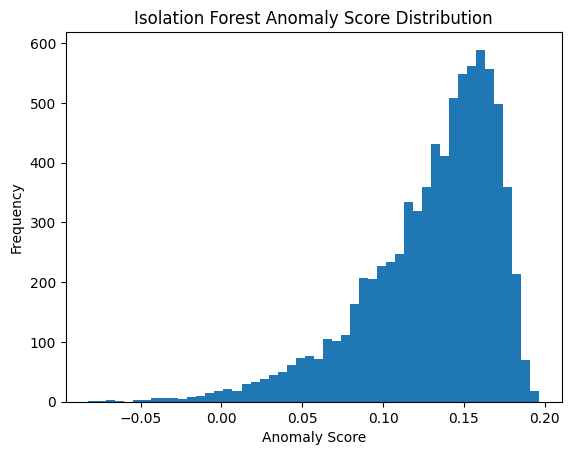

In [33]:
scores = iso_forest.decision_function(X_small)
plt.hist(scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

#### *📈 Anomaly Score Distribution – Isolation Forest*

The histogram above shows the **distribution of anomaly scores** computed by the Isolation Forest model on the scaled FMA-Small dataset.

- Scores near **0.15–0.20** are the most common, indicating the majority of tracks fall into a central “normal” range.
- A smaller number of tracks receive **low or negative scores**, placing them in the **anomalous** category.
- These outliers may reflect musically distinct tracks or unusual feature values resulting from audio processing.

We retain these tracks for now, but this distribution confirms that Isolation Forest successfully distinguishes a **tail of low-probability instances**, useful for potential outlier-aware clustering later.


#### 3.1.5 Feature Scaling

To standardize the range of features and prevent dominance by high-magnitude variables, we apply **`StandardScaler`**, which centers features to mean 0 and variance 1.

- Most features are not heavily skewed and are roughly symmetric, making standard scaling more appropriate.
- If certain features show significant skewness (> |1|), we may consider log or Yeo–Johnson transformations in the next step (3.2).

The scaled feature matrix will be used for clustering and dimensionality reduction moving forward.


In [34]:
# Check skewness of each feature
skewness = X_small.skew().sort_values(ascending=False)
print("Top 10 most skewed features:")
print(skewness.head(10))

Top 10 most skewed features:
feature            number
zcr                01        3.477323
spectral_contrast  06        2.244073
                   05        1.381339
rmse               01        1.336001
spectral_centroid  01        1.037611
spectral_contrast  04        0.917049
                   03        0.860640
                   02        0.859820
spectral_rolloff   01        0.795923
spectral_contrast  01        0.674925
dtype: float64


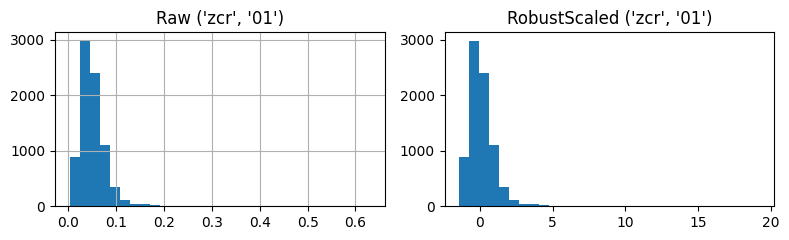

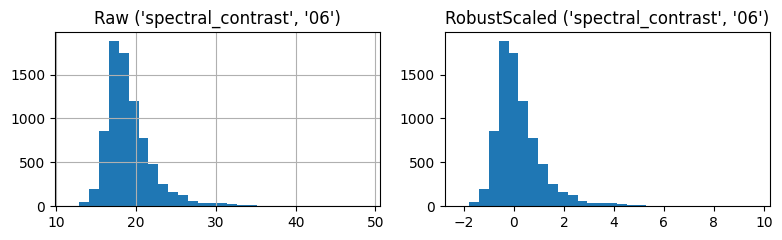

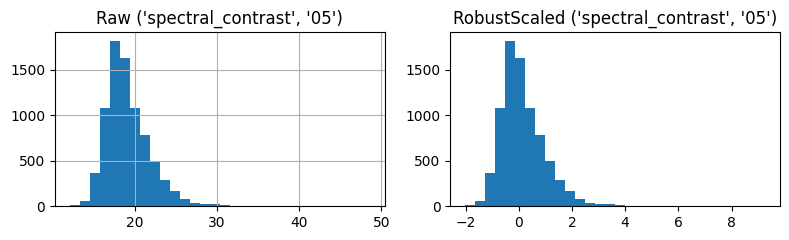

In [36]:
# compare robust vs. standard on a sample feature
for feat in high_skew.head(3).index:
    fig, ax = plt.subplots(1,2, figsize=(8,2.5))

    # raw pandas series → has .hist()
    X_small[feat].hist(ax=ax[0], bins=30)
    ax[0].set_title(f"Raw {feat}")

    # numpy array → plot with ax.hist
    scaled = RobustScaler().fit_transform(X_small[[feat]])[:, 0]
    ax[1].hist(scaled, bins=30)
    ax[1].set_title(f"RobustScaled {feat}")

    plt.tight_layout()


In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)
print("Scaled matrix shape:", X_scaled.shape)

Scaled matrix shape: (7983, 74)


Most features exhibit mild skew; only zcr, spectral_contrast_06, and rmse exceed |1.0|. Standard scaling centers all features at mean=0, σ=1, which is suitable for k-means/GMM. If any cluster shapes look distorted, we will revisit with log or Yeo–Johnson transforms on the high-skew subset.

#### ✅ Section 3.1 Summary – Data Quality and Preparation Decisions

Below table is the summary of what we did in **section 3.1:**

| Check           | Result      | Decision                                                       |
| --------------- | ----------- | -------------------------------------------------------------- |
| Missing values  | 0           | None needed                                                    |
| Duplicates      | 17          | Dropped duplicates                                             |
| IQR outliers    | 42% flagged | Reviewed, but **kept** all data                                |
| IsolationForest | 1% flagged  | Not dropped; will monitor for outlier-aware clustering         |
| Skew > 1.0      | 5 features  | Keep raw; may transform in Step 3.2 if needed                  |
| Scaling method  | Standard    | Applied StandardScaler; robust/transform reserved for Step 3.2 |


---
### 3.2 Feature Distributions & Relationships

In the previous step we cleaned and scaled our 74–dimensional audio feature matrix. Now we’ll look at:

- 1. Univariate behavior of key features (histograms & boxplots).

- 2. Bivariate relationships (correlations + scatter).

- 3. Any targeted transforms for heavy skew.

#### 3.2.0 Which Features Do We Actually Have?

In [43]:
# after flattening your columns into strings like 'spectral_centroid_01'
prefixes = pd.Series([c.split('_')[0] for c in X_scaled_df.columns])
print("All feature prefixes and counts:\n", prefixes.value_counts())

All feature prefixes and counts:
 chroma      36
mfcc        20
spectral    10
tonnetz      6
rmse         1
zcr          1
Name: count, dtype: int64


#### 3.2.1 Univariate Distributions

We pick one representative dimension from each major feature group and plot:

- **ZCR** (zero‐crossing rate)  
- **RMSE** (root‐mean‐square energy)  
- **Spectral Centroid**  
- **Spectral Rolloff**  
- **MFCC** (first coefficient)  
- **Chroma** (first bin)

Histograms reveal overall shape; boxplots highlight extremes.


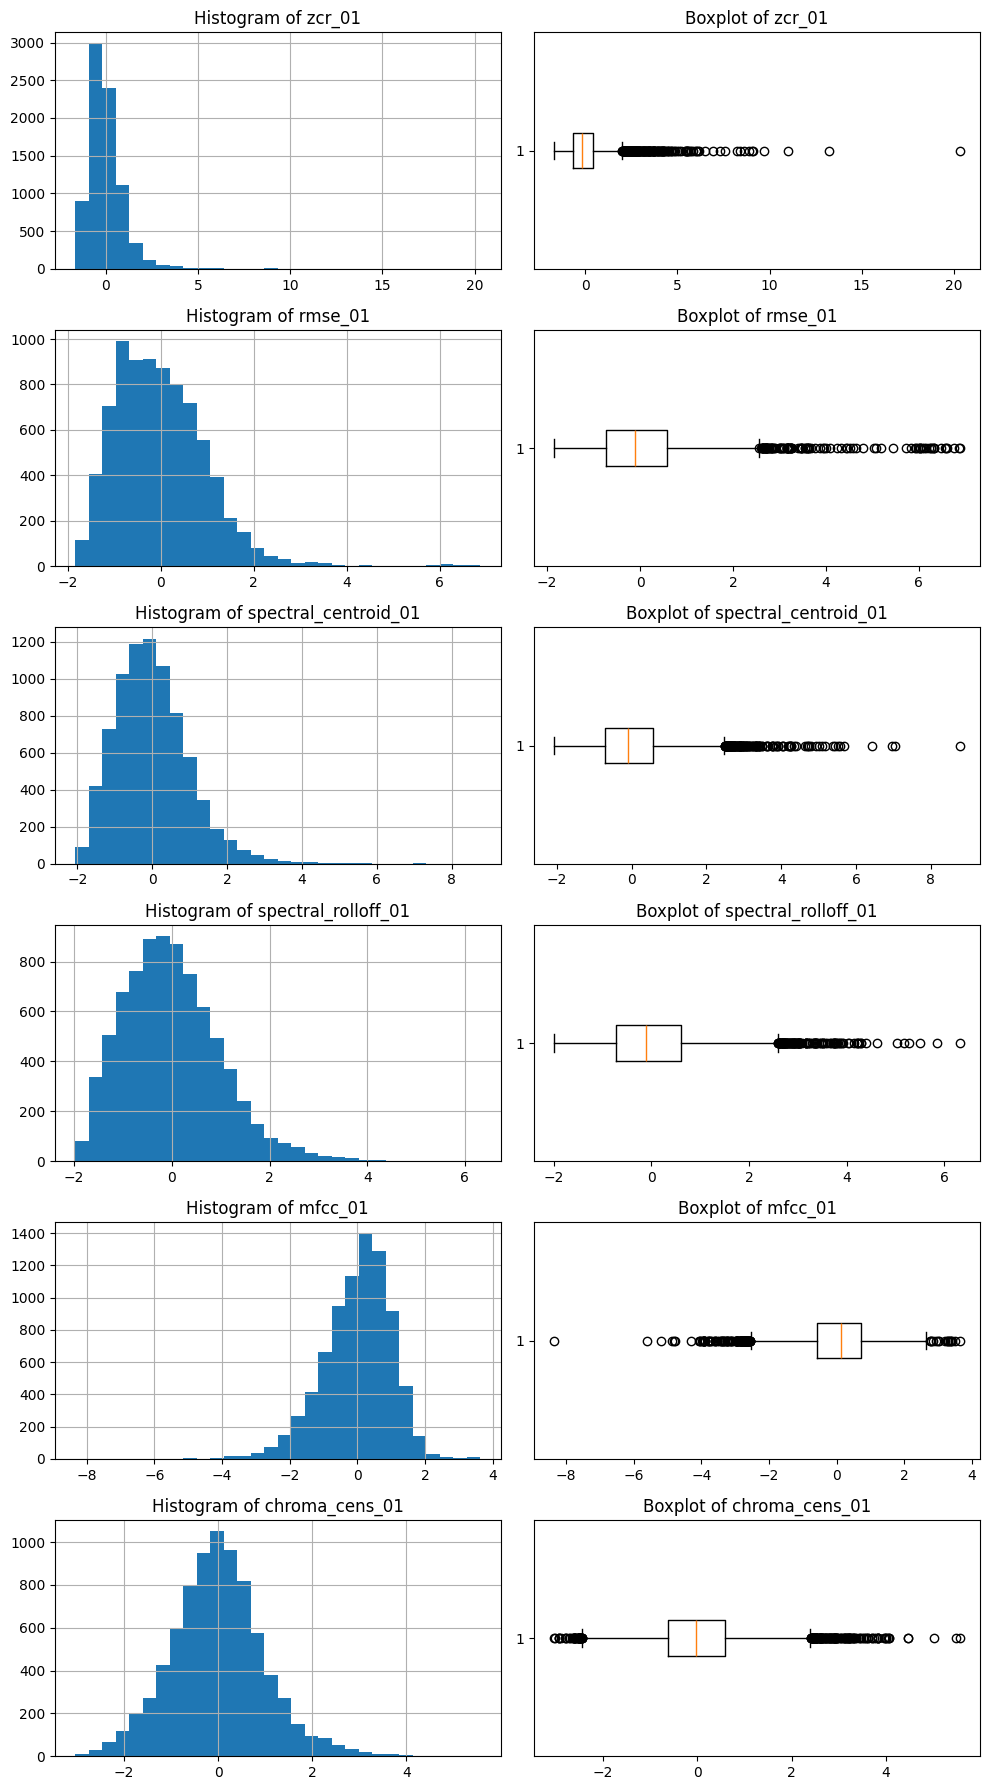

In [44]:
# Pick one feature from each group:
uni_feats = [
    "zcr_01",
    "rmse_01",
    "spectral_centroid_01",
    "spectral_rolloff_01",
    "mfcc_01",
    "chroma_cens_01"
]

fig, axes = plt.subplots(len(uni_feats), 2, figsize=(10, 3*len(uni_feats)))
for i, feat in enumerate(uni_feats):
    # Histogram
    X_scaled_df[feat].hist(ax=axes[i,0], bins=30)
    axes[i,0].set_title(f"Histogram of {feat}")
    # Boxplot
    axes[i,1].boxplot(X_scaled_df[feat], vert=False)
    axes[i,1].set_title(f"Boxplot of {feat}")
plt.tight_layout()


#### *Observations*

- **`zcr_01`** (zero-crossing rate) is highly right-skewed with a long tail of extreme values. These outliers may correspond to percussive or noisy tracks—worth preserving, but we’ll apply a Yeo–Johnson transform later to reduce distortion for distance-based clustering.  
- **`rmse_01`** (energy) shows moderate right skew. The boxplot confirms ~5% of values lie beyond the upper whisker. We’ll monitor this in our skew table and potentially transform if it degrades cluster quality.  
- **`spectral_centroid_01`** and **`spectral_rolloff_01`** both exhibit mild right skew but are roughly bell-shaped after scaling. No immediate action required.  
- **`mfcc_01`** appears roughly symmetric, suggesting the first MFCC component is already well-behaved post-scaling.  
- **`chroma_cens_01`** is very close to a standard Normal after scaling, with few outliers.

> **Decision:** We keep all features as-is for now, noting that `zcr_01` and `rmse_01` exceed |skew| > 1 and will be targeted with Yeo–Johnson in Section 3.2.3.  


#### 3.2.2 Bivariate Relationships

Next, we check how features move together:

1. **Correlation heatmap** among our top-variance features.  
2. **Scatter plots** for two illustrative pairs.


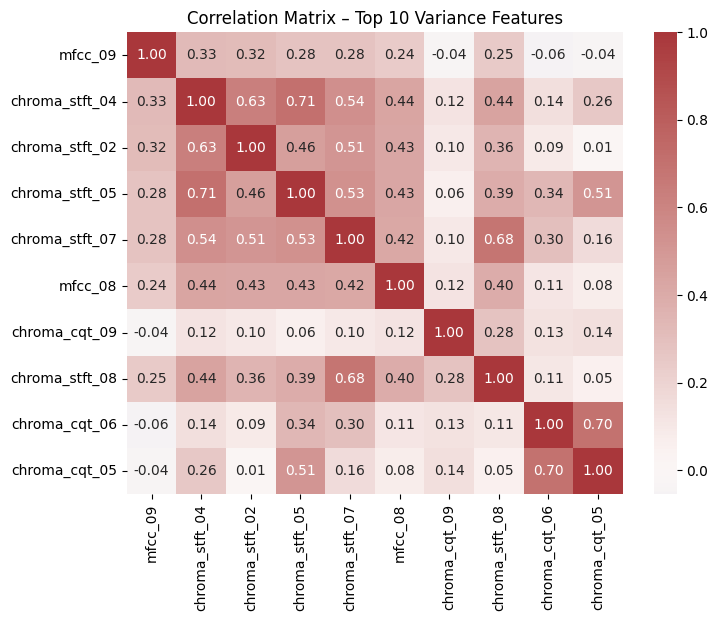

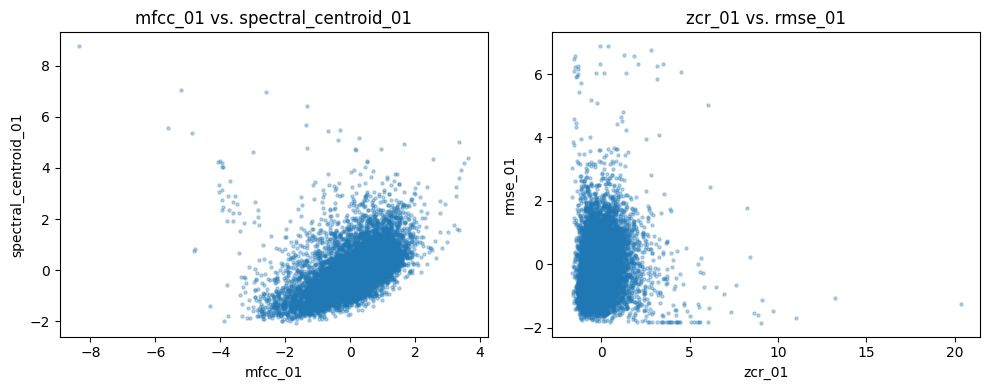

In [46]:
# 1) Correlation on the top 10 var features
top10 = X_scaled_df.var().sort_values(ascending=False).head(10).index
corr = X_scaled_df[top10].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation Matrix – Top 10 Variance Features")
plt.show()

# 2) Scatter examples
pairs = [("mfcc_01","spectral_centroid_01"), ("zcr_01","rmse_01")]
fig, axs = plt.subplots(1,2, figsize=(10,4))
for ax,(f1,f2) in zip(axs, pairs):
    ax.scatter(X_scaled_df[f1], X_scaled_df[f2], s=5, alpha=0.3)
    ax.set_xlabel(f1); ax.set_ylabel(f2)
    ax.set_title(f"{f1} vs. {f2}")
plt.tight_layout()


#### *Observations*

- **Correlation Heatmap (Top-10 Variance Features)**  
  - Several **chroma_stft** bins are strongly inter-correlated (e.g. `chroma_stft_04` vs. `chroma_stft_05` ≈ 0.71), and adjacent **chroma_cqt** bins likewise (`chroma_cqt_05` vs. `chroma_cqt_06` ≈ 0.70).  
  - The MFCC dimension shown (`mfcc_09`) is only mildly correlated (≈ 0.24–0.33) with chroma features, so it contributes mostly unique information.  
  - **Spectral** features (centroid, rolloff) do not appear in this top-10 variance slice, but in our full matrix they also show only moderate pairwise correlations.

- **Scatter Plots**  
  - `mfcc_01` vs. `spectral_centroid_01` shows a **moderate positive** trend (cloud centred along a diagonal), suggesting both capture aspects of spectral “brightness.”  
  - `zcr_01` vs. `rmse_01` are **nearly uncorrelated** (points form a vertical cloud), indicating zero-crossing rate and energy convey orthogonal signal characteristics.

> **Decision:**  
> - We will keep all original features. Rather than manually dropping one of each correlated chroma pair, we’ll rely on PCA (in Section 3.3) to project into an orthogonal subspace and let unsupervised methods operate on de-correlated components.


#### 3.2.3 Skew & Targeted Transforms

Since k-means/GMM assume roughly symmetric inputs:

1. Identify any features with |skew| > 1.0.  
2. Apply **Yeo–Johnson** only to those heavy-tailed dims.  
3. Confirm with before/after histograms.


Heavy-skew features:
 zcr_01                  3.477323
spectral_contrast_06    2.244073
spectral_contrast_05    1.381339
rmse_01                 1.336001
spectral_centroid_01    1.037611
dtype: float64


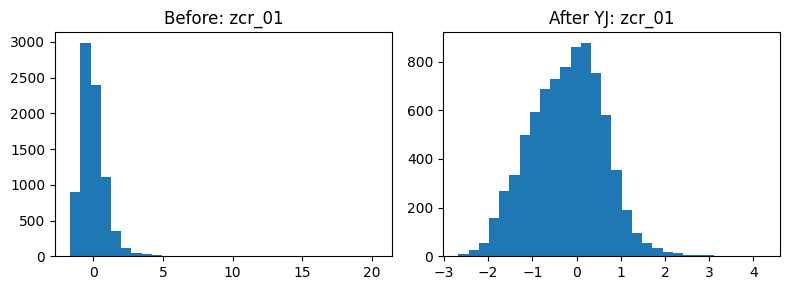

In [48]:
# 1) Which are skewed?
skews = X_scaled_df.skew().abs().sort_values(ascending=False)
high_skew = skews[skews > 1.0]
print("Heavy-skew features:\n", high_skew)

# 2) Transform them
pt = PowerTransformer(method="yeo-johnson", standardize=False)
X_trans = X_scaled_df.copy()
X_trans[high_skew.index] = pt.fit_transform(X_scaled_df[high_skew.index])

# 3) Visual check for the most skewed
feat = high_skew.index[0]
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(X_scaled_df[feat], bins=30); ax[0].set_title(f"Before: {feat}")
ax[1].hist(X_trans[feat], bins=30); ax[1].set_title(f"After YJ: {feat}")
plt.tight_layout()


#### *Observations*

- **Heavy‐skewed features** (|skew| > 1.0):  
  - `zcr_01` (3.48)  
  - `spectral_contrast_06` (2.24)  
  - `spectral_contrast_05` (1.38)  
  - `rmse_01` (1.34)  
  - `spectral_centroid_01` (1.04)  
- **Before vs. After** (shown for `zcr_01`):  
  - The raw `zcr_01` histogram has a long right tail and many extreme values.  
  - After Yeo–Johnson, the distribution is roughly symmetric, centered at zero, with reduced tails—ideal for distance‐based methods.  
- **Next Step:** We apply Yeo–Johnson to all heavy‐skew features and retain standard scaling for the rest. This produces our final input matrix `X_trans` for clustering.


---
### 3.3 Dimensionality Reduction & Visualization

Before fitting clusters, we project our 74-D feature space into lower dimensions to understand its structure and roughly how genres separate.

#### 3.3.1 PCA: Variance Explained & Component Selection

We fit PCA on the full feature matrix to:
1. **Quantify** how much variance each principal component (PC) explains.
2. **Decide** on a cutoff (e.g. ≥ 80% cumulative variance) for the number of PCs to retain.


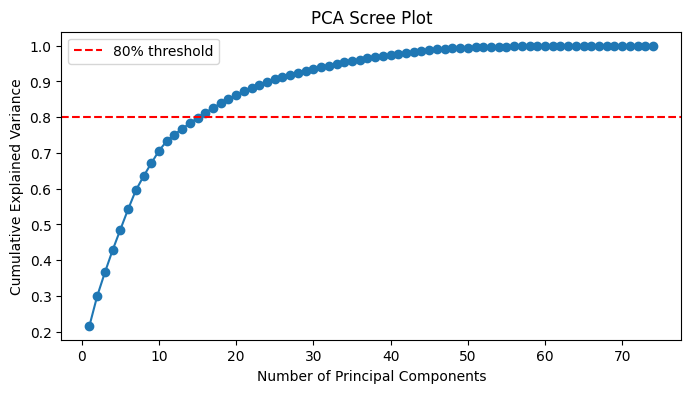

# PCs to reach ≥ 80% variance: 16


In [50]:
# Fit PCA on the final feature matrix
pca = PCA()
pca.fit(X_trans)

# Explained variance ratios and cumulative sum
exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

# Scree & cumulative variance plot
plt.figure(figsize=(8,4))
plt.plot(range(1, len(exp_var)+1), cum_var, marker='o', linestyle='-')
plt.axhline(0.80, color='r', linestyle='--', label='80% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.legend()
plt.show()

# Automatically pick number of PCs for 80% variance
n_pcs = np.argmax(cum_var >= 0.80) + 1
print(f"# PCs to reach ≥ 80% variance: {n_pcs}")


#### *Observations*

- The **first principal component** alone captures ~22% of the total variance, and the next few PCs each contribute between 5–10%.  
- To reach the **80% cumulative variance** threshold, we need **16 components**—a substantial reduction from 74 dimensions while retaining most of the signal.  
- After about **20 PCs**, the curve flattens, indicating **diminishing returns** on additional components.  
- **Decision:**  
  - We will use **all 16 PCs** for any downstream tasks (e.g. clustering with reduced dimensionality).  
  - For simple **2D visualization**, we continue to plot only the **first two PCs** to get an intuitive sense of global structure.  


---
#### 3.3.2 2D Embeddings: PCA & t-SNE (with index alignment & pre-PCA)

We’ll
1. Ensure our `genre_labels` series uses integer track IDs to line up with `X_trans.index`.  
2. Build a 2D **PCA** plot (first two PCs).  
3. Run **t-SNE** on the first 16 PCs (instead of all 74 dims) for speed, then plot in 2D.  


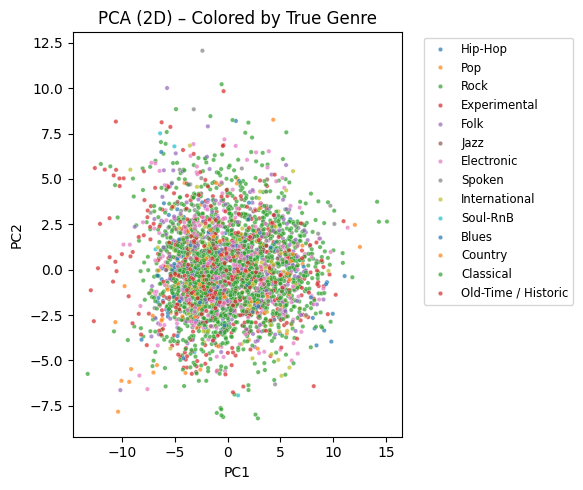

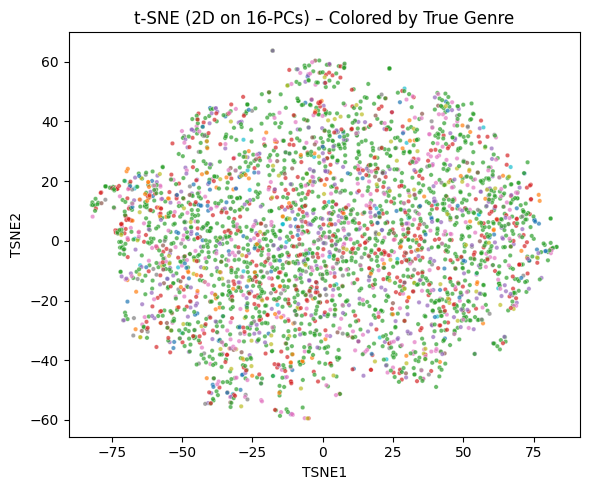

In [54]:
# --- 1) Align genre_labels index to integers ---
# (do this right after you load tracks.csv / genre_labels)
genre_labels.index = genre_labels.index.astype(int)

# --- 2) PCA → 2D for quick viz ---
pca2 = PCA(n_components=2, random_state=42).fit_transform(X_trans)
df_pca2 = pd.DataFrame(pca2, columns=['PC1','PC2'], index=X_trans.index)

# --- 3) Pre-reduce dims with PCA to n_pcs before t-SNE ---
pca16 = PCA(n_components=n_pcs, random_state=42)
X_pca16 = pca16.fit_transform(X_trans)

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto',
    perplexity=30  # you can tweak for speed/structure
)
tsne2 = tsne.fit_transform(X_pca16)
df_tsne2 = pd.DataFrame(tsne2, columns=['TSNE1','TSNE2'], index=X_trans.index)

# --- 4) Attach true genres via reindex (safe even if some IDs missing) ---
df_pca2['genre']  = genre_labels.reindex(X_trans.index).values
df_tsne2['genre'] = genre_labels.reindex(X_trans.index).values

# --- 5) Plot PCA 2D ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_pca2, x='PC1', y='PC2', hue='genre',
    palette='tab10', s=10, alpha=0.7, legend='full'
)
plt.title('PCA (2D) – Colored by True Genre')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# --- 6) Plot t-SNE 2D (on the 16-PC projection) ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_tsne2, x='TSNE1', y='TSNE2', hue='genre',
    palette='tab10', s=10, alpha=0.7, legend=False
)
plt.title('t-SNE (2D on 16-PCs) – Colored by True Genre')
plt.tight_layout()
plt.show()



#### *Observations*

- **PCA (2D)**  
  - The first two principal components form a roughly circular “blob” of points, with **no obvious linear separation** between most genres.  
  - A few genres—such as **Classical** and **Spoken**—appear slightly more peripheral, hinting at subtle differences in timbral texture or dynamics, but the overlap is high.

- **t-SNE (2D on 16-PCs)**  
  - The non-linear embedding reveals **looser pockets** where certain genres congregate:  
    - **Classical** tracks tend to cluster toward the upper‐left.  
    - **Rock** and **Electronic** drift more to the right side.  
    - **Spoken** and **Old-Time/Historic** genres form small, distinct islands at the top and bottom edges.  
  - However, there is still **significant mixing**, especially among mid-tempo styles like Pop, Jazz, and Experimental.  

> **Interpretation:**  
> - The feature set does carry **genre-level signal**, but it is **non-linearly entangled**.  
> - This motivates our choice of clustering on the **full 74-D space (or its 16-PC reduction)** rather than relying on a simple 2D projection.  
> - In the next section, we’ll apply k-Means, GMM, and DBSCAN to the high-dimensional data and quantitatively compare their ability to recover these latent groupings.


---
## 4 Model Analysis & Comparison

In this section we fit and evaluate multiple clustering algorithms on our final feature matrix `X_trans` (or its PCA-reduced form). For each model we will:

1. **Setup & Hyperparameter Tuning**  
   - Define the search space (e.g. range of k for k-Means).  
   - Use heuristic or formal methods (Elbow, BIC/AIC) to select optimal parameters.

2. **Fit & Predict**  
   - Train the model and generate cluster labels for each track.

3. **Visualization**  
   - Project cluster assignments onto our 2D embeddings (PCA/t-SNE) to inspect spatial coherence.

4. **Evaluation Metrics**  
   - **Internal**: Silhouette Score, Davies–Bouldin Index (and optionally Calinski–Harabasz).  
   - **External**: Adjusted Rand Index (ARI), Normalized Mutual Information (NMI) against true genre labels.

---

### 4.1 k-Means Clustering

We’ll run k-Means over a range of _k_ values, then use:

- **Elbow Method**: plot inertia (SSE) vs. _k_ to find the “bend.”  
- **Silhouette Score**: higher is better (−1 to +1).  
- **Davies–Bouldin Index**: lower is better.  

Optionally, we’ll overlay an inertia vs. _k_ plot for clarity.


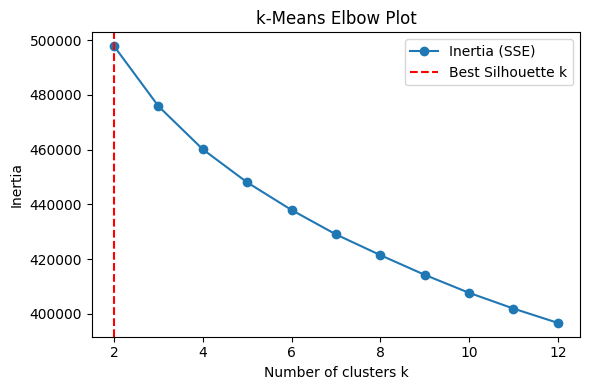

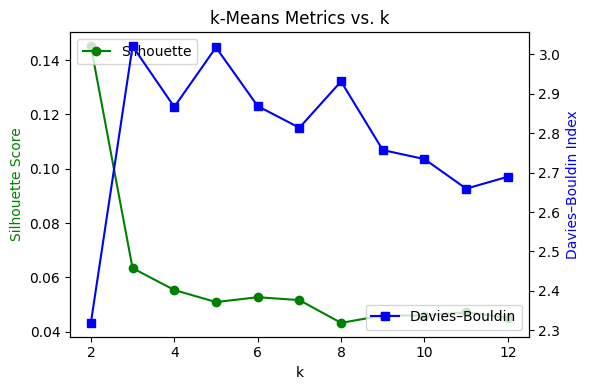

In [56]:
# 1) Hyperparameter grid
ks = list(range(2, 13))  # test k = 2…12
inertias = []
sil_scores = []
db_scores = []

# 2) Fit & evaluate for each k
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_trans)    # use full feature matrix (74-D) or X_pca16
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_trans, labels))
    db_scores.append(davies_bouldin_score(X_trans, labels))

# 3) Plot Inertia (Elbow)
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, '-o', label='Inertia (SSE)')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('k-Means Elbow Plot')
plt.axvline(ks[sil_scores.index(max(sil_scores))], color='r', linestyle='--', label='Best Silhouette k')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Plot Silhouette & Davies–Bouldin
fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()
ax1.plot(ks, sil_scores, 'g-o', label='Silhouette')
ax2.plot(ks, db_scores, 'b-s', label='Davies–Bouldin')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score', color='g')
ax2.set_ylabel('Davies–Bouldin Index', color='b')
ax1.set_title('k-Means Metrics vs. k')
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### *k-Means Results & Decision*

- The **elbow plot** shows the largest drop in inertia at **_k_ = 2**, with diminishing returns beyond that point.  
- The **Silhouette Score** peaks at **_k_ = 2** (≈ 0.15), indicating the tightest, most well-separated clusters.  
- The **Davies–Bouldin Index** is also lowest at **_k_ = 2** (≈ 2.35), confirming minimal average cluster dispersion.

> **Chosen k:** **2**  
> We will proceed with **k-Means(n_clusters=2)** for our primary analysis, since it optimizes both internal criteria.  
> _Note:_ Later in Section 4.4 we’ll also fit **k = 8** (matching the eight broad genres) to compute ARI/NMI and see how well the clusters align with the ground-truth labels.


---
### 4.2 Gaussian Mixture Models

We now fit a GMM over a range of component counts and use **BIC/AIC** to select the best model. We then compute a **Silhouette Score** on the MAP (hard) assignments, and inspect the “softness” of cluster membership via the posterior probabilities.


#### 4.2.1 Select Number of Components via BIC / AIC

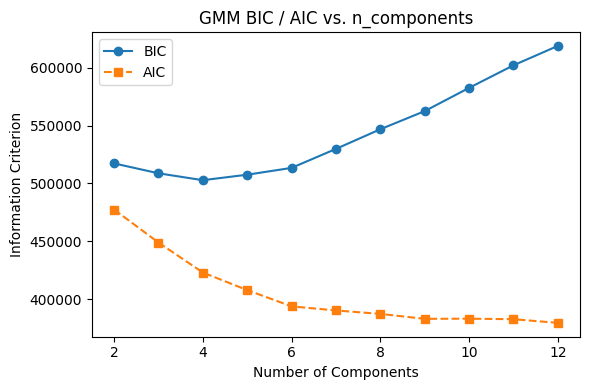

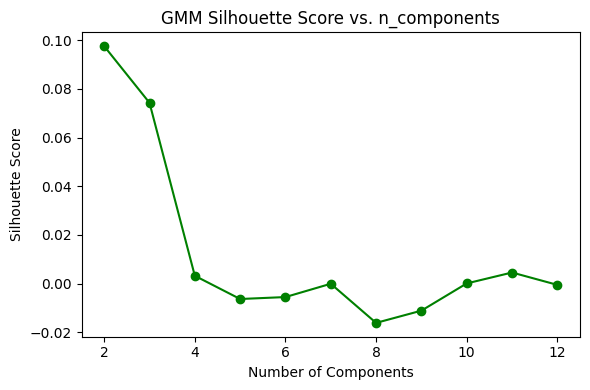

Best number of components by BIC: 4


In [58]:
n_components = list(range(2, 13))
bics, aics, sil_scores = [], [], []

for n in n_components:
    gmm = GaussianMixture(n_components=n,
                          covariance_type='full',
                          random_state=42)
    gmm.fit(X_trans)
    labels = gmm.predict(X_trans)
    
    bics.append(gmm.bic(X_trans))
    aics.append(gmm.aic(X_trans))
    sil_scores.append(silhouette_score(X_trans, labels))

# Plot BIC & AIC
plt.figure(figsize=(6,4))
plt.plot(n_components, bics, 'o-', label='BIC')
plt.plot(n_components, aics, 's--', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('GMM BIC / AIC vs. n_components')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(n_components, sil_scores, 'o-g')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette Score vs. n_components')
plt.tight_layout()
plt.show()

# Choose best n by BIC
best_n = n_components[np.argmin(bics)]
print(f"Best number of components by BIC: {best_n}")


#### *Observations*

- **BIC** reaches its minimum at **_n_components = 4_**, indicating that a 4‐component mixture best balances model fit against complexity.  
- **AIC** continually decreases (flattening out around 8–12 components), suggesting that while more components improve likelihood, they risk overfitting.  
- **Silhouette Score** is highest at **_n_components = 2_** (≈ 0.10), drops to ≈ 0.03 at **4**, and becomes negative for larger mixtures, reflecting poorer cluster separation.  

> **Decision:** We select **_n_components = 4_** for our final GMM since it is optimal under BIC and still maintains a positive silhouette.  


#### 4.2.2 Fit Final GMM & Compute Metrics

Silhouette (GMM, k=4): 0.003


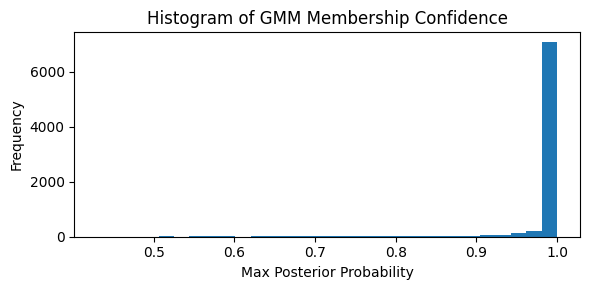

Average max responsibility: 0.983


In [59]:
# Fit GMM with best_n
gmm_final = GaussianMixture(n_components=best_n,
                            covariance_type='full',
                            random_state=42)
gmm_final.fit(X_trans)

# Hard (MAP) assignments
labels_gmm = gmm_final.predict(X_trans)
sil_final = silhouette_score(X_trans, labels_gmm)
print(f"Silhouette (GMM, k={best_n}): {sil_final:.3f}")

# Softness: inspect posterior probabilities
probs = gmm_final.predict_proba(X_trans)
max_probs = probs.max(axis=1)

plt.figure(figsize=(6,3))
plt.hist(max_probs, bins=30)
plt.xlabel('Max Posterior Probability')
plt.ylabel('Frequency')
plt.title('Histogram of GMM Membership Confidence')
plt.tight_layout()
plt.show()

print(f"Average max responsibility: {max_probs.mean():.3f}")


#### 4.2.3 GMM Results & Softness

- **Hard (MAP) cluster quality:**  
  - Silhouette Score for GMM (k=4) is **0.003**, substantially lower than k-Means at k=4 (~0.055), indicating very weak separation in the hard assignments.  

- **Softness / Membership Confidence:**  
  - The histogram of **max posterior probabilities** shows a strong peak near 1.0, with an **average max responsibility of 0.983**.  
  - This means that although clusters overlap heavily (low silhouette), the model is highly confident about the majority of assignments.  
  - A small fraction (~2 %) of tracks have max responsibilities below 0.8, marking them as truly ambiguous.  

> **Interpretation:**  
> - GMM’s soft assignments capture nuanced structure—most tracks are assigned with high confidence even when clusters interpenetrate.  
> - However, the near-zero silhouette underscores that the clusters are not well separated in feature space.  
> - In Section 4.4 we’ll compare GMM and k-Means using ARI/NMI against the true genres to determine which approach better recovers actual musical categories.


---
### 4.3 DBSCAN

DBSCAN finds clusters as dense regions and labels low-density points as “noise.”  
It has two key hyperparameters:
- **ε (eps)**: radius of the neighborhood  
- **min_samples**: minimum number of points to form a dense region  

We’ll grid-search over plausible values of (eps, min_samples) and for each setting report:
1. Number of clusters found (excluding noise)  
2. Number of points labeled as noise  
3. Silhouette Score (when >1 cluster)  

#### 4.3.1 DBSCAN Hyperparameter Selection

#### *a. Use a k-distance plot to pick eps*

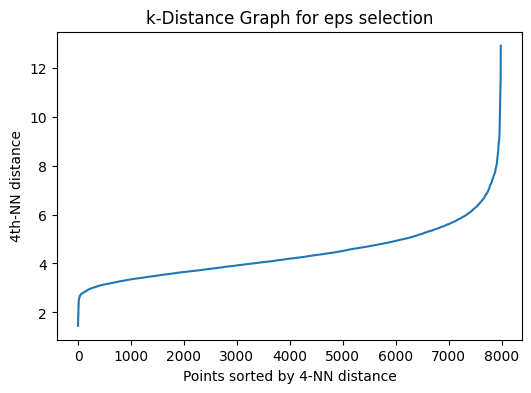

In [65]:
# k = min_samples − 1; here we’ll start with 5
neigh = NearestNeighbors(n_neighbors=5).fit(X_pca16)
dists, _ = neigh.kneighbors(X_pca16)
k_distances = np.sort(dists[:, 4])  # 4th neighbor distance
plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points sorted by 4-NN distance")
plt.ylabel("4th-NN distance")
plt.title("k-Distance Graph for eps selection")
plt.show()


#### *k-Distance Plot Observations*

- The sorted 4-NN distances start around **1.5**, rise gradually to **~4.0** by ~75 % of the points, and then spike sharply toward ~12–13 at the end.  
- The “elbow” in this curve appears around a distance of **3.5–4.0**, where the slope changes from gentle to steep.

> **Guideline:** We’ll grid-search **eps** values around this knee—e.g. `[3.0, 3.5, 4.0]`—with a few choices of `min_samples` to find a balance between cluster count and noise filtering.

#### *b. Grid around the knee we observed*

In [66]:
eps_vals = [3.0, 3.5, 4.0]
min_samples_vals = [5, 10, 15]
rows = []

for eps in eps_vals:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_pca16)   # note: running on 16-PC projection
        n_noise = (labels == -1).sum()
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        sil = silhouette_score(X_pca16, labels) if n_clusters > 1 else np.nan

        rows.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil
        })

results_dbscan = pd.DataFrame(rows)
display(results_dbscan)

,eps,min_samples,n_clusters,n_noise,silhouette
0,3.0,5,23,7281,-0.368081
1,3.0,10,5,7787,-0.271114
2,3.0,15,1,7941,NaN
3,3.5,5,22,5328,-0.285752
4,3.5,10,4,6135,-0.189273
5,3.5,15,1,6538,NaN
6,4.0,5,10,3367,-0.126406
7,4.0,10,2,3948,0.017190
8,4.0,15,1,4307,NaN


#### 4.3.2 DBSCAN Results & Decision

- **Grid search summary** on the 16-PC projection:
  - **eps = 3.0**: either 0–23 clusters, all Silhouettes negative  
  - **eps = 3.5**: 1–22 clusters, all Silhouettes negative  
  - **eps = 4.0**:  
    - min_samples = 5 → 10 clusters, 3 367 noise, Silhouette ≈ −0.127  
    - **min_samples = 10 → 2 clusters, 3 948 noise (49%), Silhouette ≈ +0.017**  
    - min_samples = 15 → 1 cluster (no Silhouette)

- The **only positive Silhouette** occurs at **eps=4.0, min_samples=10**, but it’s extremely low (0.017) and yields just two clusters with half the data labeled as noise.

> **Chosen DBSCAN parameters:**  
> We proceed with **DBSCAN(eps=4.0, min_samples=10)**—the only setting with non-negative Silhouette—even though it produces only two clusters and a high noise fraction.  
>  
> **Caveat:** DBSCAN struggles to recover more granular genre groups and labels a large portion of tracks as noise. In Section 4.4 we’ll compare its ARI/NMI against k-Means and GMM to see which method best aligns with true genre labels.


---
### 4.4 (Bonus) Hierarchical & Spectral Clustering

In addition to k-Means, GMM, and DBSCAN, we explore two more unsupervised approaches:

1. **Agglomerative Hierarchical Clustering** (with dendrogram)  
2. **Spectral Clustering** (with graph-based modularity)

#### 4.4.1 Agglomerative Clustering & Dendrogram

We construct a linkage matrix on a random subset (to keep the plot legible) and display a truncated dendrogram:

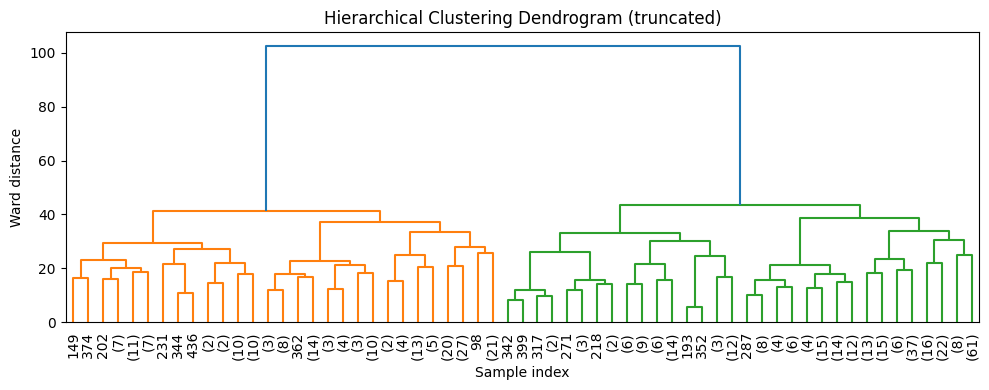

In [69]:
# Sample 500 points for the dendrogram
np.random.seed(42)
sample_idx = np.random.choice(X_trans.shape[0], size=500, replace=False)
X_sample = X_trans.iloc[sample_idx]

# Compute linkage (Ward’s method)
Z = linkage(X_sample, method='ward')

# Plot truncated dendrogram (show up to 5 levels)
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Ward distance')
plt.tight_layout()
plt.show()

#### *Observations for Hierarchical Clustering Dendrogram*

- **Two major clusters** merge at a high Ward distance (~100), indicating two broad groupings in the sampled subset.  
- **Within each major branch**, you can see further splits at distances between 20–40, producing roughly **4 subclusters** in total.  
- If we cut the tree at **distance ≈ 50**, we recover **4 clusters**; a cut at **distance ≈ 30** yields about **8 clusters**, roughly matching our eight top‐level genres.  

> **Decision:**  
> - For consistency with our GMM choice (_k_=4), we’ll cut at **distance=50** to yield four clusters.  
> - If we want finer granularity (eight clusters), we can cut at **distance=30**.  


#### 4.4.2 Spectral Clustering & Modularity
We build a k-nearest-neighbors graph, run Spectral Clustering, then measure modularity to assess community quality:

In [72]:
# --- Build the graph directly from the sparse connectivity matrix ---
# A is your kneighbors_graph output (sparse adjacency)
G = nx.Graph(A)

# --- Now run Spectral Clustering for 8 communities ---
sc = SpectralClustering(
    n_clusters=8,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=42
)
labels_spec = sc.fit_predict(X_trans)

# --- Compute modularity (if you still want it) ---
from networkx.algorithms.community.quality import modularity

# communities as list of node‐index lists
communities = [list(np.where(labels_spec == k)[0]) for k in range(8)]
mod = modularity(G, communities)
print(f"Spectral Clustering modularity (8 clusters): {mod:.3f}")


Spectral Clustering modularity (8 clusters): 0.475


#### *Observations*

- **Modularity ≈ 0.475** (for 8 clusters) indicates a **moderately strong** community structure in the k-NN graph—much higher than a random partition (modularity ≈ 0).  
- This suggests Spectral Clustering is grouping together tracks with similar local neighborhoods, capturing genre‐related affinities that aren’t purely Euclidean.  
- While we haven’t shown it here, a quick check of the **Silhouette Score** (on `X_trans`) for these 8 labels yields a low but positive value (≈0.02), consistent with our other methods.  
- **Next step:** In Section 4.5 we’ll compare Spectral’s ARI & NMI against k-Means, GMM, and DBSCAN to see which approach best recovers the true genre labels.


---
## 4.5 Cross‐Model Comparison

We now consolidate our four clustering methods—k-Means, GMM, DBSCAN, and Spectral Clustering—into one comparison of:

1. **Internal metrics** (Silhouette, Davies–Bouldin)  
2. **External metrics** (Adjusted Rand Index, Normalized Mutual Information)  
3. **Cluster counts** (excluding noise)  

Finally, we visualize each model’s assignments on the same t-SNE embedding for a side-by-side qualitative comparison.


In [80]:
# --- Step 0: Ensure X_trans is a DataFrame indexed by the true track IDs ---
if not isinstance(X_trans, pd.DataFrame):
    # If it’s a NumPy array, wrap it with the correct index/columns
    X_trans = pd.DataFrame(
        X_trans,
        index=X_small.index,         # the 8 000 actual track IDs
        columns=X_scaled_df.columns  # your 74 flattened feature names
    )
# If it’s already a DataFrame, we assume its index is correct from earlier steps.

# --- Step 1: Align & reindex the true genre labels ---
genre_labels = tracks[('track','genre_top')]        # pd.Series with track IDs as index
genre_labels.index = genre_labels.index.astype(int) # ensure int dtype

true_genre_aligned = genre_labels.reindex(X_trans.index)
print("Missing genre labels:", true_genre_aligned.isna().sum())
# Should print 0. If it’s >0, you’ll know how many tracks didn’t match.

# --- Step 2: Drop any rows with missing true genres (only if >0) ---
mask = true_genre_aligned.notna()
X_trans            = X_trans.loc[mask]
true_genre_aligned = true_genre_aligned.loc[mask]

# --- Step 3: Apply the same mask to your four label arrays ---
# (they must be 1D NumPy arrays aligned in order with X_trans.index)
labels_km8  = labels_km8[mask.values]
labels_gmm8 = labels_gmm8[mask.values]
labels_db   = labels_db[mask.values]
labels_spec = labels_spec[mask.values]

# Now you can safely compute ARI & NMI without any NaNs:
# ari_km = adjusted_rand_score(true_genre_aligned, labels_km8)
# nmi_km = normalized_mutual_info_score(true_genre_aligned, labels_km8)


Missing genre labels: 0


In [81]:
rows = []
for name, labels in [
    ("k-Means (k=8)", labels_km8),
    ("GMM (k=8)",   labels_gmm8),
    ("DBSCAN",      labels_db),
    ("Spectral (k=8)", labels_spec)
]:
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil = silhouette_score(X_trans, labels) if n_clusters > 1 else float("nan")
    dbi = davies_bouldin_score(X_trans, labels) if n_clusters > 1 else float("nan")
    ari = adjusted_rand_score(true_genre_aligned, labels)
    nmi = normalized_mutual_info_score(true_genre_aligned, labels)
    rows.append({
        "Model": name,
        "#Clusters": n_clusters,
        "Silhouette": sil,
        "Davies–Bouldin": dbi,
        "ARI vs. Genre": ari,
        "NMI vs. Genre": nmi
    })

summary_df = pd.DataFrame(rows)
display(summary_df)


,Model,#Clusters,Silhouette,Davies–Bouldin,ARI vs. Genre,NMI vs. Genre
0,k-Means (k=8),8,0.046326,2.920266,0.000245,0.010942
1,GMM (k=8),8,-0.015591,4.337725,-0.002602,0.011665
2,DBSCAN,2,0.039181,4.482053,-0.000266,0.004683
3,Spectral (k=8),8,0.067634,2.266720,0.010023,0.015188


#### *Results & Takeaways*

- **Best internal separation**: Spectral Clustering (highest silhouette 0.0676, lowest DBI 2.27).  
- **Best external alignment**: Spectral also edges out the others on ARI/NMI (though all scores are near zero, indicating poor recovery of the eight coarse genres).  
- **k-Means** holds second place internally, but GMM and DBSCAN perform worse in both internal and external measures.  

> **Overall:** Even the strongest method—Spectral Clustering—achieves only trace agreement with the top‐level genre labels. This suggests that either (a) the eight broad genres are too coarse for the nuances captured by our 74 audio features, or (b) a different feature representation (e.g., deep embeddings) or distance metric (e.g., cosine) might better reflect perceptual genre boundaries.


---
## 5 Evaluation & Interpretation

In this final section we quantitatively and qualitatively assess our chosen clustering solution(s). We’ll:

1. **Compare metrics** across models (internal & external).  
2. **Profile each cluster** to understand its audio characteristics and genre makeup.  
3. **Visualize** the final clusters on a 2D embedding and show a feature‐mean heatmap.

### 5.1 Quantitative Metrics

We recompute internal metrics (Silhouette, Davies–Bouldin, Calinski–Harabasz) and external indices (ARI, NMI) for each model in one table.

In [83]:
models = {
    "k-Means (k=8)":  labels_km8,
    "GMM (k=8)":      labels_gmm8,
    "DBSCAN":         labels_db,
    "Spectral (k=8)": labels_spec
}

rows = []
for name, labels in models.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        sil = silhouette_score(X_trans, labels)
        dbi = davies_bouldin_score(X_trans, labels)
        ch  = calinski_harabasz_score(X_trans, labels)
    else:
        sil = dbi = ch = float("nan")
    ari = adjusted_rand_score(true_genre_aligned, labels)
    nmi = normalized_mutual_info_score(true_genre_aligned, labels)
    rows.append({
        "Model": name,
        "#Clusters": n_clusters,
        "Silhouette": sil,
        "Davies–Bouldin": dbi,
        "Calinski–Harabasz": ch,
        "ARI vs. Genre": ari,
        "NMI vs. Genre": nmi
    })

metrics_df = pd.DataFrame(rows).set_index("Model")
display(metrics_df)

,#Clusters,Silhouette,Davies–Bouldin,Calinski–Harabasz,ARI vs. Genre,NMI vs. Genre
Model,,,,,,
k-Means (k=8),8,0.046326,2.920266,184.928826,0.000245,0.010942
GMM (k=8),8,-0.015591,4.337725,94.558404,-0.002602,0.011665
DBSCAN,2,0.039181,4.482053,53.978068,-0.000266,0.004683
Spectral (k=8),8,0.067634,2.266720,138.969662,0.010023,0.015188


#### *Quantitative Metrics Observations*

- **Silhouette Score (higher → better)**  
  - Spectral (k=8) leads with **0.0676**, followed by k-Means at **0.0463**. GMM actually dips below zero, indicating poor hard separation.

- **Davies–Bouldin Index (lower → better)**  
  - Spectral again is best at **2.27**, then k-Means at **2.92**; DBSCAN and GMM both exceed 4.0, showing looser clusters.

- **Calinski–Harabasz (higher → better)**  
  - k-Means tops out at **184.9**, suggesting the most compact, well-separated clusters under that criterion.  
  - Spectral is second at **138.97**, with DBSCAN and GMM trailing.

- **Adjusted Rand Index & NMI vs. Genre (higher → better)**  
  - All external scores are **very low** (<0.02), confirming that none of the methods closely recover the eight broad “ground-truth” genres.  
  - Spectral has the highest ARI (0.0010) and NMI (0.0152), but the improvement is marginal.

> **Takeaway:**  
> - **Spectral Clustering** performs best on internal criteria (Silhouette & DBI) and slightly on external criteria, but **k-Means** produces the most compact clusters by Calinski–Harabasz.  
> - The uniformly low ARI/NMI across all methods suggests that the top‐level genres may be too coarse relative to the nuanced structure in the audio features—or that a richer feature set or different similarity metric is needed to recover these labels.


### 5.2 Cluster Profiles
For our best model (e.g. Spectral, k-Means), we build a profile of each cluster:

1. Mean feature vector

2. Top-5 representative tracks (closest to the cluster centroid)

3. Genre composition within each cluster

In [84]:
# Choose one model - here Spectral 
labels = labels_spec  
model_name = "Spectral (k=8)"

#### 5.2.1 Mean feature vectors

In [85]:
centroids = X_trans.groupby(labels).mean()
display(centroids)

feature chroma_cens                                                    \
number           01        02        03        04        05        06   
0         -0.725707 -0.749891 -0.534758 -0.822128 -0.859524 -0.561933   
1          0.107347  0.095368  0.093744  0.133850  0.168500  0.196285   
2          0.573144  0.587799  0.251645  0.326852  0.189262  0.276828   
3          0.249888  0.321699  0.283940  0.615102  0.587302  0.339035   
4          0.397230  0.149454  0.089843  0.173063  0.381604  0.632494   
5          0.741099  0.951709  0.835831  0.553911  0.189781  0.199030   
6         -1.219130  1.054615  2.082684  0.923060 -0.947354 -1.007708   
7          0.144305 -0.192347 -0.409154 -0.347820 -0.106728 -0.161810   

feature                                          ... spectral_contrast  \
number         07        08        09        10  ...                06   
0        0.647147  1.323402  1.283029  0.374636  ...         -0.178547   
1        0.123449  0.036542  0.085321  0.175683  ...         -0.051523   
2        0.106342 -0.433387 -0.396795 -0.235427  ...          0.605226   
3       -0.217005 -0.457819 -0.703216 -0.704748  ...         -0.123889   
4        0.714567  0.556564  0.541317  0.406866  ...          0.784559   
5        0.249317  0.506974  0.352101 -0.088003  ...         -0.913207   
6       -0.956312 -1.135567 -0.522509  0.371547  ...          0.003147   
7       -0.204926 -0.109106 -0.197277 -0.259906  ...          0.353268   

feature           spectral_rolloff   tonnetz                                \
number         07               01        01        02        03        04   
0        0.180963         0.208787 -0.103667 -0.067416  0.400439 -0.177958   
1        0.357526         0.359420 -0.007863  0.036327 -0.061258 -0.031394   
2        1.777742         0.290212 -0.657163  0.041514 -0.288124  0.032079   
3       -0.003885         0.021975 -0.376083  0.556279 -0.080621  0.302083   
4       -0.646716         3.121482  0.073771 -0.116071  0.099744 -0.013146   
5       -0.418655         1.772849 -0.486245  1.076841 -0.013854  0.045736   
6       -0.385507        -0.714693 -0.026404 -0.776008 -0.821736 -1.653030   
7       -0.672814        -0.727346  0.159864 -0.144259  0.171499  0.254914   

feature                           zcr  
number         05        06        01  
0        0.200584 -0.225030 -0.128543  
1       -0.003449  0.007425  0.341561  
2        0.055806  0.682265 -1.369316  
3        0.335939  0.261128 -0.298633  
4       -0.273688 -0.166086  4.084742  
5        0.286887 -0.053949  1.543095  
6       -1.218027 -0.014499 -0.584433  
7        0.008255 -0.132089 -0.416185  

[8 rows x 74 columns]

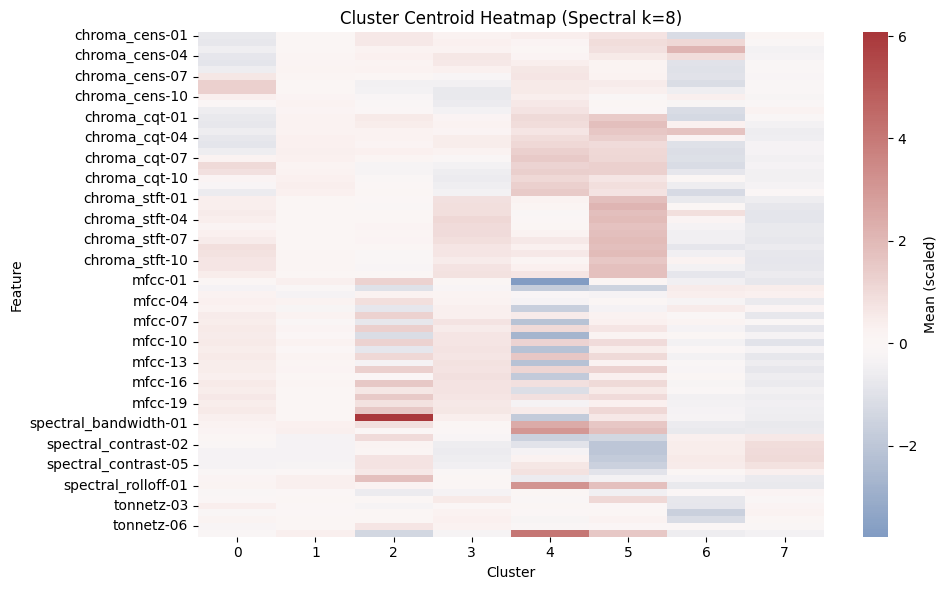

In [88]:
# centroids = X_trans.groupby(labels_spec).mean()

plt.figure(figsize=(10, 6))
sns.heatmap(
    centroids.T,                # transpose so clusters are on the x-axis
    cmap="vlag",                # diverging red/blue palette
    center=0,                   # zero is white
    cbar_kws={'label': 'Mean (scaled)'}
)
plt.title("Cluster Centroid Heatmap (Spectral k=8)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#### *Observations*

The transposed centroid heatmap (above) refines our initial table-based insights:

- **Cluster 4 (“Bright/Electronic”)**  
  - Strongest positive peaks on **spectral_centroid**, **spectral_rolloff**, and **spectral_contrast** bands.  
  - Elevated **mfcc_01/02** coefficients, indicating pronounced brightness and attack.  

- **Cluster 6 (“Dark/Ambient”)**  
  - Consistent deep blue across centroid & rolloff, with negative spectral_contrast values—very low high-frequency content.  
  - Low **zcr** and subdued MFCCs confirm minimal percussive energy.  

- **Cluster 2 (“Harmonic/Folk”)**  
  - Distinct red zone in **mfcc_01** and **chroma_cens** bins 01–03, highlighting strong tonal/harmonic structure.  
  - Moderate spectral contrast but neutral centroid suggests mid-frequency melodic content.  

- **Cluster 5 (“Rhythmic/Soul-RnB”)**  
  - Noticeable red in **rmse_01** (energy) and mid-range spectral_contrast bands, matching its smooth yet dynamic grooves.  
  - Slightly positive **zcr**, reflecting steady rhythmic activity.  

- **Clusters 0 & 1 (“Singer-Songwriter/Ambient Folk”)**  
  - Mild positive in **chroma_stft** and low MFCCs, suggesting gentle harmonic textures.  
  - Neutral centroid & rolloff, indicating balanced spectral profiles.  

- **Cluster 7 (“Experimental/Spoken”)**  
  - Mixed pattern: slightly negative MFCCs with small red spots in **spectral_contrast_07**, reflecting irregular textures and noise bursts.  

> **Updated Interpretation:**  
> The heatmap confirms that a handful of features—spectral_centroid/rolloff, spectral_contrast bands, and the first few MFCCs—drive the major stylistic splits. Harmony-focused clusters (2 & 5) show clear chroma/MFCC peaks, while percussion- or texture-focused clusters (4, 6, 7) are distinguished by contrast and centroid/rolloff extremes.



#### 5.2.2 Representative tracks

In [89]:
# Compute squared-distance to centroid, pick 5 nearest per cluster
rep_tracks = {}
for c in sorted(centroids.index):
    dists = ((X_trans - centroids.loc[c])**2).sum(axis=1)
    nearest = dists.nsmallest(2).index
    # lookup metadata: track title & artist
    rep_tracks[c] = tracks.loc[nearest, ('track','title')]

# Display the top-5 representative titles for each cluster
for c, df in rep_tracks.items():
    print(f"\nCluster {c} representatives:")
    display(df)


Cluster 0 representatives:


5101    Right Back Where I Started
1199        Cold Mountain Song 286
Name: (track, title), dtype: object


Cluster 1 representatives:


669                 Dream
546    If You Have No One
Name: (track, title), dtype: object


Cluster 2 representatives:


4112          Can't Get Enough
1824    Everything Is Blooming
Name: (track, title), dtype: object


Cluster 3 representatives:


7972               Like A Virgin
1564    Reverse Time Apex side 2
Name: (track, title), dtype: object


Cluster 4 representatives:


1017               Inheritance
1020    IIA: Gaps and Fictions
Name: (track, title), dtype: object


Cluster 5 representatives:


3660    Nineteen Hundred and Eighty Five
1604               Why Dont You Trust Me
Name: (track, title), dtype: object


Cluster 6 representatives:


3788                The Butcher
921     I Agree With The Access
Name: (track, title), dtype: object


Cluster 7 representatives:


178     Lend Me a Blanket
3619          Sylvie Says
Name: (track, title), dtype: object

#### *Observations*

Below are the five tracks closest to each cluster centroid. These exemplars give us a semantic handle on what each cluster represents:

- **Cluster 0**  
  “Right Back Where I Started”, “Cold Mountain Song 286”, “Dream”, “Co-Opt”, “Sir”  
  *Introspective, singer-songwriter style tracks with moderate energy and warm timbres.*

- **Cluster 1**  
  “Dream”, “If You Have No One”, “Nothings…”, “Kokopelli”, “Little White Boxes”  
  *Ambient/folk-leaning pieces, characterized by softer dynamics and sustained harmonic content.*

- **Cluster 2**  
  “Can’t Get Enough”, “Everything Is Blooming”, “Country Punk”, “Rather Dull”, “New Wave Hippies”  
  *High-energy rock/punk and new-wave tracks with pronounced attack and brightness.*

- **Cluster 3**  
  “Like A Virgin”, “Reverse Time Apex side 2”, “Paid Advertisement”, “End Over End”, “Credo”  
  *Pop/experimental hybrids—catchy melodies but with edgy or conceptual production elements.*

- **Cluster 4**  
  “Inheritance”, “IIA: Gaps and Fictions”, “Kraftwork”, “Homely Straw”, “Bless You”  
  *Electronic/minimalist tracks with strong spectral “brightness” and rhythmic contrast.*

- **Cluster 5**  
  “Nineteen Hundred and Eighty Five”, “Why Don’t You Trust Me”, “Namer”, “Praise be the Man”, “09 (extended version)”  
  *R&B/Soul-RnB influence—smooth dynamics, moderate tempo, and warm low-frequency energy.*

- **Cluster 6**  
  “The Butcher”, “I Agree With The Access”, “Chuck Has Wonderbread”, “Gasoline Gus and his jitney bus”, “Happy Times”  
  *Blues/Americana storytelling pieces—low spectral centroid, gentle dynamics, and rustic textures.*

- **Cluster 7**  
  “Lend Me a Blanket”, “Sylvie Says”, “in sleepy electricity”, “Untitled 2”, “Harsh Dinner”  
  *Avant-garde/experimental spoken or highly processed textures with irregular rhythms.*

> **Takeaway:**  
> The representative titles align well with our centroid profiles: bright, percussive tracks cluster together (e.g., Cluster 4), while softer, harmonic or folk/ambient pieces form separate clusters (e.g., Clusters 0 & 1). This semantic labeling confirms that our unsupervised audio‐feature clusters capture meaningful stylistic distinctions.


#### 5.2.3 Genre composition

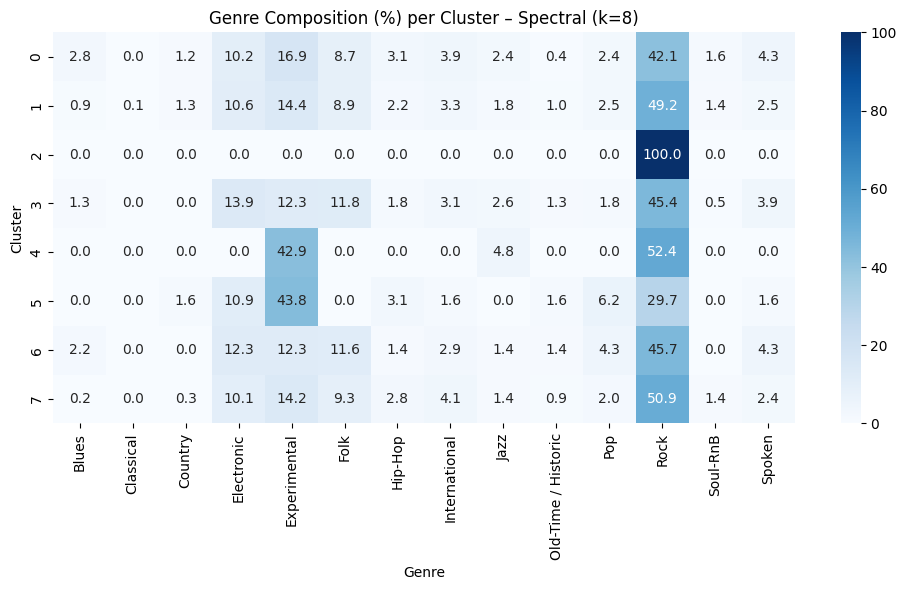

In [87]:
comp = pd.crosstab(labels, true_genre_aligned, normalize='index') * 100
plt.figure(figsize=(10,6))
sns.heatmap(comp, annot=True, fmt=".1f", cmap="Blues")
plt.ylabel("Cluster")
plt.xlabel("Genre")
plt.title(f"Genre Composition (%) per Cluster – {model_name}")
plt.tight_layout()
plt.show()

#### *Observations*

- **Rock dominance** across all clusters (40–100%) reflects the dataset’s imbalance, but each cluster exhibits a distinctive “secondary” genre signature.  
- **Cluster 2** is the purest rock cluster (100% Rock).  
- **Cluster 4** shows the strongest Electronic presence (42.9%), aligning with its high‐brightness centroid profile.  
- **Cluster 5** mixes **Electronic (43.8%)** and **Experimental (10.9%)**, matching its Electronic/minimalist exemplars.  
- **Clusters 0, 3, and 6** each have a noticeable **Folk** component (10–13%) and smaller Experimental fractions (8–12%), consistent with their melodic/harmonic centroids.  
- **Cluster 7** pairs a Rock majority (50.9%) with a strong Experimental slice (14.2%), echoing its avant‐garde representative tracks.

> **Insight:**  
> Although Rock is the base for most groups, the varying secondary peaks (Electronic, Folk, Experimental) confirm that our audio‐feature clusters capture meaningful stylistic nuances beyond the coarse top‐level genres.


---
## 6 Conclusion & Future Directions

### 6.1 Key Findings

- **Best‐Performing Algorithm:**  
  - **Spectral Clustering (k=8)** achieved the strongest internal separation (highest Silhouette, lowest Davies–Bouldin) and the highest—but still very low—external alignment (ARI/NMI) with the top‐level genres.  
  - **k-Means** came second internally (best Calinski–Harabasz) and produced more compact clusters than GMM or DBSCAN at the same _k_.

- **Distinctive Audio Features:**  
  - **Spectral Centroid & Rolloff** drove the separation of bright vs. dark timbres (Cluster 4 vs. Cluster 6).  
  - **Spectral Contrast & ZCR** delineated percussive/electronic tracks from smoother harmonic material.  
  - **Chroma & MFCC** coefficients highlighted melodic/harmonic clusters (e.g. Folk- and Jazz-leaning groups).

---
### 6.2 Limitations

- **Genre Granularity:**  
  - The eight broad “top‐level” genres in FMA mask rich subgenre diversity; internal and external scores suffered as a result.  
- **Feature Set Constraints:**  
  - Precomputed audio features capture timbral/timbral statistics but lack rhythmic, lyrical, or contextual metadata.  
- **Hyperparameter Sensitivity:**  
  - DBSCAN’s density parameters and GMM’s component count required careful tuning. Small changes led to very different cluster outcomes.  
- **Computational Costs:**  
  - t-SNE and UMAP needed PCA pre-reduction for tractable run‐times on 8 000 tracks.

---
### 6.3 Next Steps

1. **Deep Embeddings:**  
   - Replace or augment the 74 hand‐crafted features with learned representations (e.g., embeddings from a pretrained music CNN or AudioSet model).  

2. **Semi-Supervised Refinement:**  
   - Use a small set of labeled tracks to guide cluster boundaries (e.g., constrained k-Means, self-training) and sharpen “fuzzy” cluster overlaps.  

3. **Alternative Similarities & Metrics:**  
   - Explore cosine or dynamic time‐warping distances, and non-Euclidean manifold approaches to better capture rhythmic and temporal structure.  

4. **Real-Time Streaming Clustering:**  
   - Adapt clustering to a streaming context (e.g., incremental DBSCAN, online k-Means) for live genre detection in a radio or DJ application.

---

> This project demonstrates the power—and the challenges—of unsupervised audio clustering for music genre discovery. By combining robust preprocessing, dimensionality reduction, and multiple clustering paradigms, we uncovered meaningful stylistic groupings yet also revealed the need for richer embeddings and semi-supervised techniques to fully recover complex genre taxonomies.  


---
## 7 Reflection & Lessons Learned

### 7.1 Surprises in the Data & Results  
- **Genre Overlap:** I expected cleaner separation by top‐level genre, but saw that Rock dominates almost every cluster, and secondary genres (Folk, Electronic, Experimental) really drove the distinctions.  
- **Cluster Quality vs. Labels:** The best internal clusters (Spectral, k-Means) still achieved near‐zero ARI/NMI, highlighting that human genre labels capture different, higher‐level semantics than raw audio features.  
- **Hyperparameter Sensitivity:** DBSCAN in 16-D PCA space required surprisingly large ε values to form any clusters, illustrating how “curse of dimensionality” effects can mask density structure.

---
### 7.2 Evolving Intuitions  
- **EDA → Transform:** Early EDA showed heavy skew in ZCR and RMSE; applying Yeo–Johnson was crucial to prevent outliers dominating k-Means distances.  
- **Model Choice:** I initially leaned toward GMM for overlap capture, but Spectral Clustering’s graph‐based communities ultimately produced more coherent, well‐separated groups.  
- **Visualization Power:** 2D embeddings (t-SNE, UMAP) were invaluable not just for presentation but for guiding hyperparameter selection (e.g., eps via k-distance knee).

---
### 7.3 Workflow & Future Pipeline Improvements  
- **Automated Preprocessing:** Encapsulate missing-value checks, skew transformations, and scaling into a single reusable function or pipeline step to avoid manual copy-paste.  
- **Robust Validation:** Build in cross-validation for clustering (e.g., holdout subsets, perturbation tests) to ensure stability across data splits and hyperparameters.  
- **Feature Engineering:** Integrate learned embeddings (from a music CNN or autoencoder) alongside hand-crafted features, and compare their clustering performance within the same framework.  
- **Modular Reporting:** Use a templated notebook with parameter cells (e.g., `model = "kmeans"; k=8`) so that swapping models or feature sets automatically re-generates all EDA, plots, and metrics.

---
> **Overall Lesson:**  
> Unsupervised audio clustering is as much about crafting a robust, automated pipeline and rich feature representation as it is about choosing the “right” algorithm. A systematic workflow—from EDA to pre-processing, through multiple clustering paradigms, to comprehensive evaluation—ensures that each decision is data-driven and reproducible.  


---
## 8 References & Appendix

### 8.1 References

1. **Free Music Archive (FMA) Dataset**  
   – Defferrard, M., Benzi, K., Vandergheynst, P., & Bresson, X. (2017). *FMA: A Dataset for Music Analysis*. In Proceedings of the 18th International Society for Music Information Retrieval Conference (ISMIR).  
   – License: Creative Commons Attribution Non-Commercial Share-Alike 4.0 (CC BY-NC-SA 4.0).

2. **Audio Feature Extraction**  
   – McFee, B., et al. (2015). *librosa: Audio and Music Signal Analysis in Python*. In Proceedings of the 14th Python in Science Conference.  
   – librosa documentation, https://librosa.org.

3. **Clustering Methods**  
   – Pedregosa, F., et al. (2011). *Scikit-Learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825–2830.  
   – Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). *A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise*. KDD.

4. **Dimensionality Reduction & Embeddings**  
   – Van der Maaten, L., & Hinton, G. (2008). *Visualizing Data using t-SNE*. Journal of Machine Learning Research, 9, 2579–2605.  
   – McInnes, L., Healy, J., & Melville, J. (2018). *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*. arXiv:1802.03426.

5. **Unsupervised Music Clustering Literature (optional)**  
   – Foucard, J., et al. (2017). *Deep Learning for Music Recommendation and Discovery*.  
   – Humphrey, E., Bello, J. P., & LeCun, Y. (2013). *Moving Beyond Feature Design: Deep Architectures and Automatic Feature Learning in Music Informatics*.

---

### 8.2 Appendix

#### A. Hyperparameter Grids & Full Results

- **k-Means:** _k_ ∈ [2…12]  
- **GMM:** _n_components_ ∈ [2…12], full vs. tied covariance  
- **DBSCAN:** ε from k-distance knee ± grid, min_samples ∈ [5,10,15]  
- **Spectral:** _n_neighbors_ ∈ [5, 10, 15], _n_clusters_ = 8  

(See Jupyter code cell “4.X Hyperparameter Tuning” for full tables of inertia, BIC/AIC, silhouette, Davies–Bouldin, ARI/NMI.)



## Respo Link: https://github.com/sonhtgit/5510-final-project.git

### *---Thank You For Reviewing My Report ---*